# Embedding space 시각화를 통한 유사도 분석하기 

## 1. ORL face 데이터셋 살펴보기

In [1]:
import os
from pathlib import Path

In [2]:
data_dir = "../DATASET/Face-Recognition/"
phase = "train"

In [3]:
person_items = []

In [4]:
for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
    if len(files) > 0:
        for file_name in files:
            person_items.append(os.path.join(root, file_name))

In [5]:
person_items

['../DATASET/Face-Recognition/train\\s1\\1.png',
 '../DATASET/Face-Recognition/train\\s1\\10.png',
 '../DATASET/Face-Recognition/train\\s1\\2.png',
 '../DATASET/Face-Recognition/train\\s1\\3.png',
 '../DATASET/Face-Recognition/train\\s1\\4.png',
 '../DATASET/Face-Recognition/train\\s1\\5.png',
 '../DATASET/Face-Recognition/train\\s1\\6.png',
 '../DATASET/Face-Recognition/train\\s1\\7.png',
 '../DATASET/Face-Recognition/train\\s1\\8.png',
 '../DATASET/Face-Recognition/train\\s1\\9.png',
 '../DATASET/Face-Recognition/train\\s10\\1.png',
 '../DATASET/Face-Recognition/train\\s10\\10.png',
 '../DATASET/Face-Recognition/train\\s10\\2.png',
 '../DATASET/Face-Recognition/train\\s10\\3.png',
 '../DATASET/Face-Recognition/train\\s10\\4.png',
 '../DATASET/Face-Recognition/train\\s10\\5.png',
 '../DATASET/Face-Recognition/train\\s10\\6.png',
 '../DATASET/Face-Recognition/train\\s10\\7.png',
 '../DATASET/Face-Recognition/train\\s10\\8.png',
 '../DATASET/Face-Recognition/train\\s10\\9.png',
 '../DAT

In [7]:
import numpy as np

In [8]:
index = 0
faceA_path = person_items[index]

person = Path(faceA_path).parent.name
same_person_dir = Path(faceA_path).parent
same_person_fn = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]

In [9]:
np.random.choice(same_person_fn)

'6.png'

In [10]:
faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_fn))

In [13]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

In [14]:
import cv2
import matplotlib.pyplot as plt

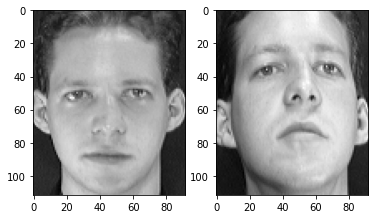

In [15]:
plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

In [16]:
while True:
    faceB_path = np.random.choice(person_items)
    if person != Path(faceB_path).parent.name:
        break

In [17]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

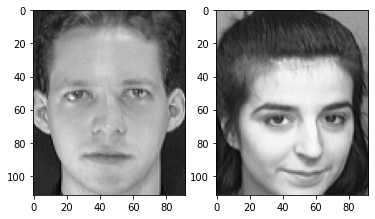

In [18]:
plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

## 2. 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [19]:
class Face_Dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.person_items = []
        for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))

        self.transformer = transformer
        
    def __len__(self):
        return len(self.person_items)
    
    def __getitem__(self, index, ):
        faceA_path = self.person_items[index]
        person = Path(faceA_path).parent.name
        same_person = np.random.randint(2)
        
        if same_person:
            same_person_dir = Path(faceA_path).parent
            same_person_fn = [fn for fn in os.listdir(same_person_dir) if fn.endswith("png")]
            faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_fn))
        else:
            while True:
                faceB_path = np.random.choice(self.person_items)
                if person != Path(faceB_path).parent.name:
                    break
                    
        faceA_image = cv2.imread(faceA_path, 0)
        faceB_image = cv2.imread(faceB_path, 0)
        
        if self.transformer:
            faceA_image = self.transformer(faceA_image)
            faceB_image = self.transformer(faceB_image)
            
        return faceA_image, faceB_image, np.array([1-same_person])

In [20]:
data_dir = "../DATASET/Face-Recognition"
trn_ds = Face_Dataset(data_dir, phase="train")

[1]


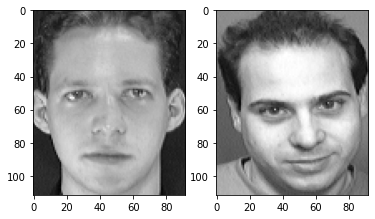

In [21]:
faceA, faceB, other = trn_ds[0]
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(faceA, cmap='gray')
plt.subplot(122)
plt.imshow(faceB, cmap='gray')
print(other)

In [22]:
from ipywidgets import interact

In [23]:
@interact(index=(0, len(trn_ds)-1))
def show_sample(index=0):
    faceA, faceB, other = trn_ds[index]
    plt.figure(figsize=(6, 6))
    plt.subplot(121)
    plt.imshow(faceA, cmap='gray')
    plt.subplot(122)
    plt.imshow(faceB, cmap='gray')
    print(other)

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [24]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [25]:
def build_transformer(image_size=100):
    transformers = {}
    transformers["train"] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    transformers["val"] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    return transformers

In [26]:
IMAGE_SIZE = 100
transformers = build_transformer(image_size=IMAGE_SIZE)

tr_dataset = Face_Dataset(data_dir, phase="train", transformer=transformers["train"])
val_dataset = Face_Dataset(data_dir, phase="val", transformer=transformers["val"])
tr_dataloader = DataLoader(tr_dataset, shuffle=True, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [27]:
def build_dataloader(data_dir, batch_size=64):
    dataloaders = {}
    
    transformers = build_transformer()
    tr_dataset = Face_Dataset(data_dir, phase="train", transformer=transformers["train"])
    dataloaders["train"] = DataLoader(tr_dataset, shuffle=True, batch_size=batch_size)
    
    val_dataset = Face_Dataset(data_dir, phase="val", transformer=transformers["val"])
    dataloaders["val"] = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
    return dataloaders

In [28]:
data_dir = "../DATASET/Face-Recognition/"
BATCH_SIZE = 64
dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)

In [29]:
for _ in range(3):
    for phase in ["train", "val"]:
        for index, batch in enumerate(dataloaders[phase]):
            faceAs = batch[0]
            faceBs = batch[1]
            others = batch[2]
                    
            if index % 100 == 0:
                print(f"{phase} - {index}/{len(dataloaders[phase])}")

train - 0/2
val - 0/1
train - 0/2
val - 0/1
train - 0/2
val - 0/1


## 3. Siamese network 아키텍처와 Loss function 구현해보기

In [30]:
import torch
from torch import nn

In [31]:
def convBlock(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
    )

In [32]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x1, x2):
        out1 = self.features(x1)
        out2 = self.features(x2)
        return out1, out2

In [34]:
IMAGE_SIZE = 100
x1 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)
x2 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)
model = SiameseNetwork()
out1, out2 = model(x1, x2)

In [35]:
print(out1.shape)
print(out2.shape)

torch.Size([1, 10])
torch.Size([1, 10])


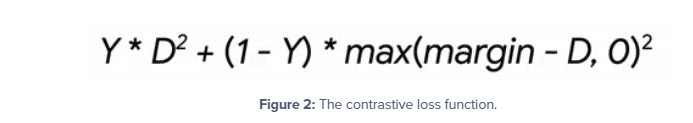
출처: https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
    
    def forward(self, z1, z2, label):
        dist = F.pairwise_distance(z1, z2, keepdim=True)
        loss = torch.mean((1-label) * torch.pow(dist, 2) + label * torch.pow(torch.clamp((self.margin - dist), min=0), 2))
        acc = ((dist > 0.6) == label).float().mean()
        return loss, acc

## 4. Few-shot learning을 위한 학습코드 작성해보기

In [37]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_acc = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            imgA = batch[0].to(device)
            imgB = batch[1].to(device)
            label = batch[2].to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                codeA, codeB = model(imgA, imgB)
            loss, acc = criterion(codeA, codeB, label)
                
            if phase == "train":
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            running_acc += acc.item()
                    
        losses[phase] = running_loss/len(dataloaders[phase])
        accuracies[phase] = running_acc/len(dataloaders[phase])
    return losses, accuracies

In [39]:
def save_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [ ]:
data_dir = "../DATASET/Face-Recognition"
is_cuda = True

IMAGE_SIZE = 100
BATCH_SIZE = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = SiameseNetwork()
model = model.to(DEVICE)
criterion = ContrastiveLoss(margin=2.0)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
num_epochs = 100

best_epoch = 0
best_score = 0.0
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    losses, accs = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_acc.append(accs["train"])
    val_acc.append(accs["val"])
    
    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}")
    print(f"{epoch}/{num_epochs} - Train acc: {accs['train']:.4f}, Val acc: {accs['val']:.4f}")
        
    if (epoch+1) % 20 == 0:
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

## 5. Tensorboard를 활용하여 Latent vector 시각화해보기

In [43]:
class Face_Dataset():
    def __init__(self, data_dir, transformer=None):
        self.person_items = []
        for (root, dirs, files) in os.walk(data_dir):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))

        self.transformer = transformer
        
    def __len__(self):
        return len(self.person_items)
    
    def __getitem__(self, index):
        face_path = self.person_items[index]
        face_image = cv2.imread(face_path, 0)
        
        if self.transformer:
            face_image = self.transformer(face_image)
        
        person_name = Path(face_path).parent.name
        return face_image, person_name

In [44]:
def build_transformer(image_size=100):
    transformer = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    return transformer

In [45]:
def load_model(ckpt_path, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = SiameseNetwork()
    model.load_state_dict(checkpoint)
    model.eval()
    return model.to(device)

In [50]:
ckpt_path = "./trained_model/model_76.pth"
is_cuda = False
DEVICE = torch.device('cuda' if is_cuda and torch.cuda.is_available() else 'cpu')

transformer = build_transformer()
dataset = Face_Dataset(data_dir, transformer=transformer)
dataloader = DataLoader(dataset, shuffle=False, batch_size=1)
model = load_model(ckpt_path, DEVICE)

FileNotFoundError: [Errno 2] No such file or directory: './trained_model/model_76.pth'

In [41]:
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

In [ ]:
writer = SummaryWriter('runs/face_features')

In [ ]:
all_images = []
all_labels = []
all_embeds = []

for idx, sample in enumerate(dataloader):
    image = sample[0]
    label = sample[1]

    with torch.no_grad():
        embed = model(image.to(device))
    embed = embed.detach().cpu().numpy()
    
    image = make_grid(image, normalize=True).permute(1,2,0)
    image = cv2.resize(np.array(image), dsize=(80, 80), interpolation=cv2.INTER_NEAREST)
    
    all_images.append(image)
    all_labels.append(label)
    all_embeds.append(embed)

all_images = torch.Tensor(np.moveaxis(np.stack(all_images, axis=0), 3, 1))
all_embeds = torch.Tensor(np.stack(all_embeds, axis=0).squeeze(1))
all_labels = np.stack(all_labels, axis=1).squeeze(0)

writer.add_embedding(all_embeds, label_img=all_images, metadata=all_labels)
writer.close()